This is a ipython notebook for multimodal compact bilinear pooling(MCB).

We first define the network.

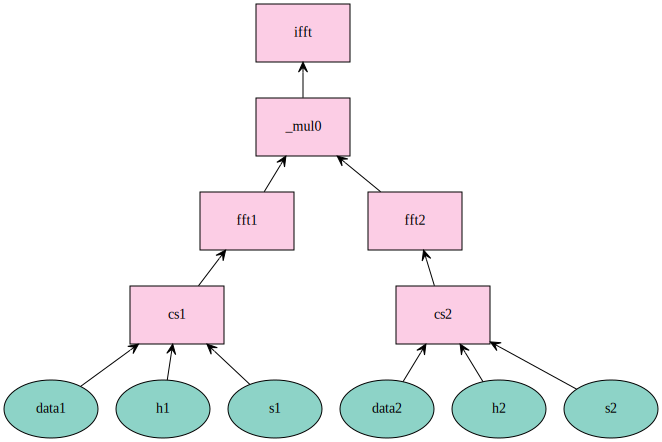

In [1]:
import mxnet as mx
import numpy as np
out_dim = 6
compute_size = 128
D1 = mx.sym.Variable('data1')
S1 = mx.sym.Variable('s1')
H1 = mx.sym.Variable('h1')
D2 = mx.sym.Variable('data2')
S2 = mx.sym.Variable('s2')
H2 = mx.sym.Variable('h2')

cs1 = mx.sym.CountSketch( data = D1,s=S1, h = H1 ,name='cs1',out_dim = out_dim) 
cs2 = mx.sym.CountSketch( data = D2,s=S2, h = H2 ,name='cs2',out_dim = out_dim) 
fft1 = mx.sym.FFT(data = cs1, name='fft1', compute_size = compute_size) 
fft2 = mx.sym.FFT(data = cs2, name='fft2', compute_size = compute_size) 
c = fft1 * fft2
out = mx.sym.IFFT(data = c, name='ifft', compute_size = compute_size) 
mx.viz.plot_network(out)

Based on your preference, you can choose to remove the last IFFT block. Notice that if you remove the IFFT, the output will have shape:(N,out_dim*2) as the output is complex.

Then we can print out all the arguments in this model.

In [2]:
print(out.list_arguments())

['data1', 'h1', 's1', 'data2', 'h2', 's2']


We can then declare the context for this model.

In [3]:
N = 5   # batch size
in_dim = 20   #input data size
#ctx_list = {'ctx': mx.gpu(0),'cs1_data':(N,in_dim),'cs1_h':(1,in_dim),'cs1_s':(1,in_dim),'cs2_data':(N,in_dim),'cs2_h':(1,in_dim),'cs2_s':(1,in_dim), 'type_dict': {'cs1_data': np.float32,'cs1_h':np.float32,'cs1_s':np.float32,'cs2_data':np.float32,'cs2_h':np.float32,'cs2_s':np.float32}}
ctx_list = {'ctx': mx.gpu(0),'data1':(N,in_dim),'h1':(1,in_dim),'s1':(1,in_dim),'data2':(N,in_dim),'h2':(1,in_dim),'s2':(1,in_dim), 'type_dict': {'data1': np.float32,'h1':np.float32,'s1':np.float32,'data2':np.float32,'h2':np.float32,'s2':np.float32}}

#ctx_list = {'ctx': mx.gpu(0),'cs1_data':(N,in_dim),'cs2_data':(N,in_dim), 'type_dict': {'cs1_data': np.float32,'cs2_data':np.float32}}

We use simple_bind() to bind the data to all free variables. This function first inferences the shapes of all free variables by using the provided data shape, and then allocate and bind data, which can be accessed by the attribute arg_arrays of the returned executor.

In [4]:
exe = out.simple_bind(**ctx_list)
args = dict(zip(out.list_arguments(), exe.arg_arrays))
for name in args:
    print(name, args[name].shape, args[name].context)

('h2', (1L, 20L), gpu(0))
('s2', (1L, 20L), gpu(0))
('s1', (1L, 20L), gpu(0))
('h1', (1L, 20L), gpu(0))
('data1', (5L, 20L), gpu(0))
('data2', (5L, 20L), gpu(0))


Then we initialize the arguments.

In [5]:
for name in args:
    data = args[name]
    if 'data' in name:
        data[:] = mx.random.uniform(-10, 10, data.shape)
    if 'h' in name:
        temp = np.random.randint(0, out_dim, data.shape)
        data[:] = mx.nd.array(temp)
    if '_s' in name:
        temp = np.random.randint(0, 2, data.shape)*2-np.ones(data.shape)
        data[:] = mx.nd.array(temp)

We can do the forward operation now. We need to normalize the output if we use IFFT block. If we don't have the IFFT block, we can call exe.outputs[0].asnumpy()[:,0::2] to obtain the real parts of the output.
To show the output from gpu, we use asnumpy().

In [6]:
exe.forward(is_train=False)
Y = exe.outputs[0].asnumpy()/out_dim
#print(Y)

We can also test the backward operation. We declare the up level gradient. We have gradients for cs1_data and cs2_data.

In [7]:
out_grad = mx.random.uniform(-0.1, 0.1, (N,out_dim))
exe.backward(out_grad)
#print(exe.grad_arrays[0].asnumpy())
#print(exe.grad_arrays[3].asnumpy())